<a href="https://colab.research.google.com/github/Gh0st116/music-recommendation/blob/main/clustering_music_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Spotify API](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)

In [1]:
!pip install spotipy

# Imports

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
from skimage import io

# Datasets

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/sthemonica/music-clustering/main/Dados/Dados_totais.csv")
data_genres = pd.read_csv("https://raw.githubusercontent.com/sthemonica/music-clustering/main/Dados/data_by_genres.csv")
data_years = pd.read_csv("https://raw.githubusercontent.com/sthemonica/music-clustering/main/Dados/data_by_year.csv")

In [4]:
data.head()

valence  year  acousticness       artists  danceability  duration_ms  \
0    0.285  2000       0.00239      Coldplay         0.429       266773   
1    0.613  2000       0.14300       OutKast         0.843       270507   
2    0.400  2000       0.00958   Linkin Park         0.556       216880   
3    0.543  2000       0.00664  3 Doors Down         0.545       233933   
4    0.760  2000       0.03020        Eminem         0.949       284200   

   energy  explicit                      id  instrumentalness  key  liveness  \
0   0.661         0  3AJwUDP919kvQ9QcozQPxg          0.000121   11    0.2340   
1   0.806         1  0I3q5fE6wg7LIfHGngUTnV          0.000000    4    0.0771   
2   0.864         0  60a0Rd6pjrkxjPbaKzXjfq          0.000000    3    0.2090   
3   0.865         0  6ZOBP3NvffbU4SZcrnt1k6          0.000011   11    0.1680   
4   0.661         1  3yfqSUWxFvZELEM4PmlwIR          0.000000    5    0.0454   

   loudness  mode                 name  popularity  speechiness    tempo  \
0    -7.227     1               Yellow          84       0.0281  173.372   
1    -5.946     0          Ms. Jackson          80       0.2690   94.948   
2    -5.870     0           In the End          84       0.0584  105.143   
3    -5.708     0           Kryptonite          78       0.0286   99.009   
4    -4.244     0  The Real Slim Shady          80       0.0572  104.504   

                   artists_song  
0             Coldplay - Yellow  
1         OutKast - Ms. Jackson  
2      Linkin Park - In the End  
3     3 Doors Down - Kryptonite  
4  Eminem - The Real Slim Shady

In [5]:
data["year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [6]:
data.shape

(20311, 19)

## Removing unnecessary columns and rows

In [7]:
data = data.drop(["explicit", "key", "mode"], axis=1)
data.head(2)

valence  year  acousticness   artists  danceability  duration_ms  energy  \
0    0.285  2000       0.00239  Coldplay         0.429       266773   0.661   
1    0.613  2000       0.14300   OutKast         0.843       270507   0.806   

                       id  instrumentalness  liveness  loudness         name  \
0  3AJwUDP919kvQ9QcozQPxg          0.000121    0.2340    -7.227       Yellow   
1  0I3q5fE6wg7LIfHGngUTnV          0.000000    0.0771    -5.946  Ms. Jackson   

   popularity  speechiness    tempo           artists_song  
0          84       0.0281  173.372      Coldplay - Yellow  
1          80       0.2690   94.948  OutKast - Ms. Jackson

In [8]:
data.isna().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
id                  0
instrumentalness    0
liveness            0
loudness            0
name                0
popularity          0
speechiness         0
tempo               0
artists_song        0
dtype: int64

In [9]:
data_genres.head(2)

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834    0.3616 -31.514333     0.040567   75.336500   
1  0.450678          0.477762    0.1310 -16.854000     0.076817  120.285667   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5

In [10]:
data_genres = data_genres.drop(["key", "mode"], axis=1)
data_genres.head(2)

genres  acousticness  danceability   duration_ms    energy  \
0  21st century classical      0.979333      0.162883  1.602977e+05  0.071317   
1                   432hz      0.494780      0.299333  1.048887e+06  0.450678   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.606834    0.3616 -31.514333     0.040567   75.336500  0.103783   
1          0.477762    0.1310 -16.854000     0.076817  120.285667  0.221750   

   popularity  
0   27.833333  
1   52.500000

In [11]:
data_genres.isna().sum()

genres              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
dtype: int64

In [12]:
data_years.head(2)

mode  year  acousticness  danceability    duration_ms    energy  \
0     1  1921      0.886896      0.418597  260537.166667  0.231815   
1     1  1922      0.938592      0.482042  165469.746479  0.237815   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.344878   0.20571 -17.048667     0.073662  101.531493  0.379327   
1          0.434195   0.24072 -19.275282     0.116655  100.884521  0.535549   

   popularity  key  
0    0.653333    2  
1    0.140845   10

In [13]:
data_years["year"].unique()

array([1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

In [14]:
data_years = data_years[data_years["year"] >= 1970]
data_years["year"].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [15]:
data_years = data_years.drop(["key", "mode"], axis=1)
data_years.head(2)

year  acousticness  danceability  duration_ms    energy  instrumentalness  \
49  1970      0.460057      0.506308  242852.1515  0.495633          0.127567   
50  1971      0.458336      0.504274  260511.7935  0.496361          0.125018   

    liveness   loudness  speechiness       tempo   valence  popularity  
49  0.212269 -11.772558     0.051681  117.111610  0.572075     34.3945  
50  0.214915 -12.079936     0.059422  118.272247  0.574913     34.4475

In [16]:
data_years.reset_index()

index  year  acousticness  danceability    duration_ms    energy  \
0      49  1970      0.460057      0.506308  242852.151500  0.495633   
1      50  1971      0.458336      0.504274  260511.793500  0.496361   
2      51  1972      0.460043      0.520999  245914.228500  0.504526   
3      52  1973      0.416524      0.515449  257002.790500  0.536138   
4      53  1974      0.447207      0.515340  252555.791000  0.514724   
5      54  1975      0.433774      0.520998  254969.371500  0.523209   
6      55  1976      0.361471      0.529762  267676.967000  0.553843   
7      56  1977      0.339303      0.533324  257121.848000  0.560288   
8      57  1978      0.328969      0.540775  249051.887000  0.561429   
9      58  1979      0.295932      0.562045  252860.226500  0.591013   
10     59  1980      0.284955      0.556152  252835.533333  0.597777   
11     60  1981      0.301204      0.542185  250904.205000  0.599383   
12     61  1982      0.289580      0.564259  248357.306000  0.590919   
13     62  1983      0.294778      0.545629  251123.698500  0.601425   
14     63  1984      0.287710      0.530309  251845.256500  0.591092   
15     64  1985      0.296571      0.555642  252276.258000  0.601515   
16     65  1986      0.285081      0.540933  254708.405500  0.614955   
17     66  1987      0.311664      0.541019  247543.323077  0.579840   
18     67  1988      0.322010      0.540459  257442.589744  0.585679   
19     68  1989      0.313351      0.547227  254203.593500  0.584046   
20     69  1990      0.332870      0.535299  256451.403500  0.571591   
21     70  1991      0.332765      0.555824  245912.006154  0.559402   
22     71  1992      0.320809      0.555065  246506.460000  0.582864   
23     72  1993      0.309069      0.569878  251667.967500  0.562560   
24     73  1994      0.306234      0.552830  250992.254000  0.578773   
25     74  1995      0.302512      0.559046  246624.091500  0.578580   
26     75  1996      0.301027      0.587831  248180.983000  0.586068   
27     76  1997      0.306716      0.576814  245749.281500  0.598699   
28     77  1998      0.291489      0.586212  248542.607500  0.605198   
29     78  1999      0.271590      0.582158  245177.745259  0.637523   
30     79  2000      0.289323      0.590918  242724.642638  0.625413   
31     80  2001      0.286842      0.583318  240307.796010  0.626986   
32     81  2002      0.282624      0.576160  239503.283000  0.641270   
33     82  2003      0.256471      0.575763  244670.575230  0.660165   
34     83  2004      0.280559      0.567680  237378.708037  0.648868   
35     84  2005      0.255764      0.572281  237229.588205  0.653209   
36     85  2006      0.279986      0.568230  234042.914359  0.650326   
37     86  2007      0.254081      0.563414  241049.962564  0.668305   
38     87  2008      0.249192      0.579193  240107.315601  0.671461   
39     88  2009      0.261929      0.564190  238140.013265  0.670749   
40     89  2010      0.242687      0.572488  242811.804563  0.681778   
41     90  2011      0.273183      0.552867  236998.787308  0.648301   
42     91  2012      0.249953      0.570882  245807.457584  0.656571   
43     92  2013      0.257488      0.571148  242267.661437  0.645597   
44     93  2014      0.249313      0.589948  233728.314713  0.648795   
45     94  2015      0.253952      0.593774  230029.046606  0.627064   
46     95  2016      0.284171      0.600202  221396.510295  0.592855   
47     96  2017      0.286099      0.612217  211115.696787  0.590421   
48     97  2018      0.267633      0.663500  206001.007133  0.602435   
49     98  2019      0.278299      0.644814  201024.788096  0.593224   
50     99  2020      0.219931      0.692904  193728.397537  0.631232   

    instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0           0.127567  0.212269 -11.772558     0.051681  117.111610  0.572075   
1           0.125018  0.214915 -12.079936     0.059422  118.272247  0.574913   
2           0.11488

# Plot analysis

In [17]:
fig = px.line(data_years, x="year", y="loudness", markers=True, title="Loudness variation through the years")
fig.show()

In [18]:
fig_go = go.Figure()

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["acousticness"], name="Acousticness"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["valence"], name="Valence"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["danceability"], name="Danceability"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["energy"], name="Energy"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["instrumentalness"], name="Instrumentalness"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["liveness"], name="Liveness"))

fig_go.add_trace(go.Scatter(x=data_years["year"], y=data_years["speechiness"], name="Speechiness"))

fig_go.show()

In [19]:
# Correlational matrix
fig_corr = px.imshow(data.corr(), text_auto=True, title="Correlational matrix")
fig_corr.show()

<ipython-input-19-c1dc0339814e>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In this matrix we see a stronger correlation between loudness and energy, popularity and year and an inverse correlation between instrumentalness and acousticness with loudness. \\
This correlation means, for example, that the louder a song is, the more energetic it gets, while the more instrumental or acoustic it is, the quieter it gets.

# Clusterization by genre

## PCA and StandardScaler

In [20]:
data_genres

genres  acousticness  danceability   duration_ms  \
0     21st century classical      0.979333      0.162883  1.602977e+05   
1                      432hz      0.494780      0.299333  1.048887e+06   
2                      8-bit      0.762000      0.712000  1.151770e+05   
3                         []      0.651417      0.529093  2.328809e+05   
4                 a cappella      0.676557      0.538961  1.906285e+05   
...                      ...           ...           ...           ...   
2968                    zolo      0.222625      0.547082  2.580991e+05   
2969                 zouglou      0.161000      0.863000  2.063200e+05   
2970                    zouk      0.263261      0.748889  3.060728e+05   
2971            zurich indie      0.993000      0.705667  1.984173e+05   
2972                  zydeco      0.421038      0.629409  1.716717e+05   

        energy  instrumentalness  liveness   loudness  speechiness  \
0     0.071317          0.606834  0.361600 -31.514333     0.040567   
1     0.450678          0.477762  0.131000 -16.854000     0.076817   
2     0.818000          0.876000  0.126000  -9.180000     0.047000   
3     0.419146          0.205309  0.218696 -12.288965     0.107872   
4     0.316434          0.003003  0.172254 -12.479387     0.082851   
...        ...               ...       ...        ...          ...   
2968  0.610240          0.143872  0.204206 -11.295878     0.061088   
2969  0.909000          0.000000  0.108000  -5.985000     0.081300   
2970  0.622444          0.257227  0.089678 -10.289222     0.038778   
2971  0.172667          0.468633  0.179667 -11.453333     0.348667   
2972  0.609369          0.019248  0.255877  -9.854825     0.050491   

           tempo   valence  popularity  
0      75.336500  0.103783   27.833333  
1     120.285667  0.221750   52.500000  
2     133.444000  0.975000   48.000000  
3     112.857352  0.513604   20.859882  
4     112.110362  0.448249   45.820071  
...          ...       ...         ...  
2968  125.494919  0.596155   33.778943  
2969  119.038000  0.845000   58.000000  
2970  101.965222  0.824111   46.666667  
2971   91.278000  0.739000    0.000000  
2972  126.366087  0.808544   30.261905  

[2973 rows x 12 columns]

In [21]:
data_genres["genres"].value_counts().sum()

2973

In [22]:
data_genreless = data_genres.drop("genres", axis=1)
data_genreless

acousticness  danceability   duration_ms    energy  instrumentalness  \
0         0.979333      0.162883  1.602977e+05  0.071317          0.606834   
1         0.494780      0.299333  1.048887e+06  0.450678          0.477762   
2         0.762000      0.712000  1.151770e+05  0.818000          0.876000   
3         0.651417      0.529093  2.328809e+05  0.419146          0.205309   
4         0.676557      0.538961  1.906285e+05  0.316434          0.003003   
...            ...           ...           ...       ...               ...   
2968      0.222625      0.547082  2.580991e+05  0.610240          0.143872   
2969      0.161000      0.863000  2.063200e+05  0.909000          0.000000   
2970      0.263261      0.748889  3.060728e+05  0.622444          0.257227   
2971      0.993000      0.705667  1.984173e+05  0.172667          0.468633   
2972      0.421038      0.629409  1.716717e+05  0.609369          0.019248   

      liveness   loudness  speechiness       tempo   valence  popularity  
0     0.361600 -31.514333     0.040567   75.336500  0.103783   27.833333  
1     0.131000 -16.854000     0.076817  120.285667  0.221750   52.500000  
2     0.126000  -9.180000     0.047000  133.444000  0.975000   48.000000  
3     0.218696 -12.288965     0.107872  112.857352  0.513604   20.859882  
4     0.172254 -12.479387     0.082851  112.110362  0.448249   45.820071  
...        ...        ...          ...         ...       ...         ...  
2968  0.204206 -11.295878     0.061088  125.494919  0.596155   33.778943  
2969  0.108000  -5.985000     0.081300  119.038000  0.845000   58.000000  
2970  0.089678 -10.289222     0.038778  101.965222  0.824111   46.666667  
2971  0.179667 -11.453333     0.348667   91.278000  0.739000    0.000000  
2972  0.255877  -9.854825     0.050491  126.366087  0.808544   30.261905  

[2973 rows x 11 columns]

In [23]:
SEED = 1224
np.random.seed(SEED)

In [24]:
pca_pipeline = Pipeline([("scaler", StandardScaler()), ("PCA", PCA(n_components=2, random_state=SEED))])

In [25]:
genre_embedding_pca = pca_pipeline.fit_transform(data_genreless)
projection = pd.DataFrame(columns=["x", "y"], data=genre_embedding_pca)

In [26]:
projection

x         y
0     5.910268 -0.011146
1     2.787093  4.498483
2    -0.757538 -1.258495
3     1.020521 -0.931690
4     0.753911 -0.999861
...        ...       ...
2968 -0.475136 -0.017126
2969 -3.026756 -1.304983
2970 -0.832511 -1.089726
2971  1.774790 -3.695233
2972 -1.028069 -1.390709

[2973 rows x 2 columns]

# K-Means

In [27]:
kmeans_pca = KMeans(n_clusters=10, verbose=True, random_state=SEED)

kmeans_pca.fit(projection)

data_genres["cluster_pca"] = kmeans_pca.predict(projection)
projection["cluster_pca"] = kmeans_pca.predict(projection)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Initialization complete
Iteration 0, inertia 2503.831624731712.
Iteration 1, inertia 2197.423820601579.
Iteration 2, inertia 2124.602371955593.
Iteration 3, inertia 2109.2640057596227.
Iteration 4, inertia 2099.976066151632.
Iteration 5, inertia 2092.1748625640435.
Iteration 6, inertia 2083.6336891284204.
Iteration 7, inertia 2074.936680348689.
Iteration 8, inertia 2067.071815417272.
Iteration 9, inertia 2061.674092248215.
Iteration 10, inertia 2056.5676086189915.
Iteration 11, inertia 2045.8908906852766.
Iteration 12, inertia 2029.6972873826671.
Iteration 13, inertia 2011.0245915461123.
Iteration 14, inertia 2004.2157571594903.
Iteration 15, inertia 2002.4640275616403.
Iteration 16, inertia 2001.2406581418472.
Iteration 17, inertia 2000.0606617179728.
Iteration 18, inertia 1998.1598777568465.
Iteration 19, inertia 1996.8203114252997.
Iteration 20, inertia 1996.0814661573963.
Iteration 21, inertia 1995.4978500372688.
Iteration 22, inertia 1995.2903703207494.
Iteration 23, inertia 1995.

In [28]:
projection

x         y  cluster_pca
0     5.910268 -0.011146            5
1     2.787093  4.498483            9
2    -0.757538 -1.258495            2
3     1.020521 -0.931690            7
4     0.753911 -0.999861            7
...        ...       ...          ...
2968 -0.475136 -0.017126            0
2969 -3.026756 -1.304983            6
2970 -0.832511 -1.089726            2
2971  1.774790 -3.695233            7
2972 -1.028069 -1.390709            2

[2973 rows x 3 columns]

In [29]:
projection["genres"] = data_genres["genres"]

In [30]:
projection

x         y  cluster_pca                  genres
0     5.910268 -0.011146            5  21st century classical
1     2.787093  4.498483            9                   432hz
2    -0.757538 -1.258495            2                   8-bit
3     1.020521 -0.931690            7                      []
4     0.753911 -0.999861            7              a cappella
...        ...       ...          ...                     ...
2968 -0.475136 -0.017126            0                    zolo
2969 -3.026756 -1.304983            6                 zouglou
2970 -0.832511 -1.089726            2                    zouk
2971  1.774790 -3.695233            7            zurich indie
2972 -1.028069 -1.390709            2                  zydeco

[2973 rows x 4 columns]

# Plotting clusters

In [31]:
fig = px.scatter(
    projection, x="x", y="y", color="cluster_pca", hover_data=["x", "y", "genres"],
    title="Cluster division"
)
fig.show()

In [32]:
pca_pipeline[1].explained_variance_ratio_.sum()

0.4927066994726641

In [33]:
pca_pipeline[1].explained_variance_.sum()

5.421597305805697

# Music clusterization

In [34]:
data.head()

valence  year  acousticness       artists  danceability  duration_ms  \
0    0.285  2000       0.00239      Coldplay         0.429       266773   
1    0.613  2000       0.14300       OutKast         0.843       270507   
2    0.400  2000       0.00958   Linkin Park         0.556       216880   
3    0.543  2000       0.00664  3 Doors Down         0.545       233933   
4    0.760  2000       0.03020        Eminem         0.949       284200   

   energy                      id  instrumentalness  liveness  loudness  \
0   0.661  3AJwUDP919kvQ9QcozQPxg          0.000121    0.2340    -7.227   
1   0.806  0I3q5fE6wg7LIfHGngUTnV          0.000000    0.0771    -5.946   
2   0.864  60a0Rd6pjrkxjPbaKzXjfq          0.000000    0.2090    -5.870   
3   0.865  6ZOBP3NvffbU4SZcrnt1k6          0.000011    0.1680    -5.708   
4   0.661  3yfqSUWxFvZELEM4PmlwIR          0.000000    0.0454    -4.244   

                  name  popularity  speechiness    tempo  \
0               Yellow          84       0.0281  173.372   
1          Ms. Jackson          80       0.2690   94.948   
2           In the End          84       0.0584  105.143   
3           Kryptonite          78       0.0286   99.009   
4  The Real Slim Shady          80       0.0572  104.504   

                   artists_song  
0             Coldplay - Yellow  
1         OutKast - Ms. Jackson  
2      Linkin Park - In the End  
3     3 Doors Down - Kryptonite  
4  Eminem - The Real Slim Shady

In [35]:
data["artists_song"].value_counts()

Coldplay - Yellow                                                   1
Juice WRLD - Intro                                                  1
Carrie Underwood - The Champion - Bonus Track                       1
YoungBoy Never Broke Again - Cross Me (feat. Lil Baby and Plies)    1
Twenty One Pilots - Morph                                           1
                                                                   ..
Taylor Swift - Come Back...Be Here                                  1
Banda El Recodo - Me Gusta Todo De Ti                               1
Michael Bublé - The Christmas Song                                  1
Glee Cast - Smooth Criminal (Glee Cast Version) (feat. 2CELLOS)     1
Eminem - Darkness                                                   1
Name: artists_song, Length: 20311, dtype: int64

## One-hot encoding

In [36]:
ohe = OneHotEncoder(dtype=int)
columns_ohe = ohe.fit_transform(data[["artists"]]).toarray()

data_artistless = data.drop("artists", axis=1)

data_songs_dummies = pd.concat([data_artistless, pd.DataFrame(columns_ohe, columns=ohe.get_feature_names_out(["artists"]))], axis=1)
data_songs_dummies

valence  year  acousticness  danceability  duration_ms  energy  \
0        0.285  2000       0.00239         0.429       266773   0.661   
1        0.613  2000       0.14300         0.843       270507   0.806   
2        0.400  2000       0.00958         0.556       216880   0.864   
3        0.543  2000       0.00664         0.545       233933   0.865   
4        0.760  2000       0.03020         0.949       284200   0.661   
...        ...   ...           ...           ...          ...     ...   
20306    0.187  2020       0.57400         0.445       176250   0.330   
20307    0.240  2020       0.81500         0.467       179188   0.429   
20308    0.466  2020       0.31000         0.562       253613   0.686   
20309    0.522  2020       0.20400         0.598       230600   0.472   
20310    0.195  2020       0.00998         0.671       337147   0.623   

                           id  instrumentalness  liveness  loudness  ...  \
0      3AJwUDP919kvQ9QcozQPxg          0.000121    0.2340    -7.227  ...   
1      0I3q5fE6wg7LIfHGngUTnV          0.000000    0.0771    -5.946  ...   
2      60a0Rd6pjrkxjPbaKzXjfq          0.000000    0.2090    -5.870  ...   
3      6ZOBP3NvffbU4SZcrnt1k6          0.000011    0.1680    -5.708  ...   
4      3yfqSUWxFvZELEM4PmlwIR          0.000000    0.0454    -4.244  ...   
...                       ...               ...       ...       ...  ...   
20306  0PUkanqCGTb6qseXPKOw1F          0.000000    0.1020    -8.121  ...   
20307  6Iw6fQVKZi0fWtEQBrTFcP          0.000052    0.1770    -8.689  ...   
20308  308prODCCD0O660tIktbUi          0.022500    0.1250    -8.480  ...   
20309  2f8y4CuG57UJEmkG3ujd0D          0.000015    0.1080   -10.991  ...   
20310  5SiZJoLXp3WOl3J4C8IK0d          0.000008    0.6430    -7.161  ...   

      artists_Zara Larsson  artists_Zedd  artists_alt-J  artists_blackbear  \
0                        0             0              0                  0   
1                        0             0              0                  0   
2                        0             0              0                  0   
3                        0             0              0                  0   
4                        0             0              0                  0   
...                    ...           ...            ...                ...   
20306                    0             0              0                  0   
20307                    0             0              0                  0   
20308                    0             0              0                  0   
20309                    0             0              0                  0   
20310                    0             0              0                  0   

      artists_blink-182  artists_deadmau5  artists_for KING & COUNTRY  \
0                     0                 0                           0   
1                     0                 0                           0   
2                     0                 0                           0   
3                     0                 0                           0   
4                     0                 0                           0   
...                 ...               ...                         ...   
20306                 0                 0                           0   
20307                 0                 0                           0   
20308                 0                 0                           0   
20309                 0                 0                           0   
20310                 0                 0                           0   

       artists_fun.  artists_girl in red  artists_iann dior  
0                 0                    0                  0  
1                 0                    0                  0  
2                 0                    0                  0  
3                 0                    0                  0  
4                 0                    0                  0  
...             ...            

In [37]:
data.shape

(20311, 16)

In [38]:
data_songs_dummies.shape

(20311, 890)

In [39]:
pca_pipeline = Pipeline([("scaler", StandardScaler()), ("PCA", PCA(n_components=0.7, random_state=SEED))])

song_embedding_pca = pca_pipeline.fit_transform(data_songs_dummies.drop(["id", "name", "artists_song"], axis=1))
projection_song = pd.DataFrame(data=song_embedding_pca)

In [40]:
pca_pipeline[1].n_components_

612

# Cluster application with K-Means

In [41]:
kmeans_pca_pipeline = KMeans(n_clusters=50, verbose=False, random_state=SEED)

kmeans_pca_pipeline.fit(projection_song)

data["cluster_pca"] = kmeans_pca_pipeline.predict(projection_song)
projection_song["cluster_pca"] = kmeans_pca_pipeline.predict(projection_song)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [42]:
projection_song["artist"] = data["artists"]
projection_song["song"] = data["artists_song"]

In [43]:
projection_song

0         1         2         3         4         5         6  \
0      0.174796  0.731252  2.186797 -0.767192  0.594847  0.315968 -0.412322   
1     -1.358420  0.052935 -1.789973  1.938444  0.403606  1.023898 -1.172118   
2     -0.972077  0.658094  0.757500 -0.277350 -0.400393  0.402941  1.292960   
3     -0.926464  1.292091  0.398499 -0.997738  0.202219  0.620859 -0.527689   
4     -1.710077 -0.383502 -1.258562  1.346428  1.223591  1.744579  0.094311   
...         ...       ...       ...       ...       ...       ...       ...   
20306  1.346699 -2.775889  0.986755 -1.704967  0.103935 -0.726582  0.253808   
20307  1.269387 -2.444619  0.971408 -0.115303 -0.719597 -1.823579 -0.545186   
20308  0.781916 -1.164865  0.705256 -0.947160  1.145828 -0.472667 -0.356604   
20309  0.002454 -3.056407 -0.272934  1.436355 -0.604453  0.251492 -1.361710   
20310 -0.957008 -1.208016  1.103144  4.128170  1.026126  0.085505  1.588383   

              7         8         9  ...       605       606       607  \
0     -0.479171 -2.700668  2.109956  ... -0.009111  0.005154 -0.034027   
1      0.821698 -1.716897  0.252498  ... -0.031986  0.029708 -0.016322   
2      1.839192 -1.562236  1.410677  ...  0.017097  0.017361 -0.010979   
3      1.135529 -1.343893  1.020964  ...  0.089337  0.164777 -0.064148   
4      0.479412 -2.125376  0.389565  ... -0.011937 -0.004081 -0.017478   
...         ...       ...       ...  ...       ...       ...       ...   
20306  0.520234 -0.064513  0.204971  ... -0.235355 -0.054256  0.016922   
20307 -1.475719 -0.338390  0.272129  ... -0.183026  0.074605  0.005622   
20308  0.972512  0.900317 -0.674016  ... -0.033420 -0.157564  0.213849   
20309 -0.633245  0.280076  0.521145  ... -0.784640  0.080684  0.038379   
20310  0.567041 -1.026283  0.266124  ... -0.012069 -0.003818 -0.017675   

            608           609           610           611  cluster_pca  \
0     -0.032617  2.241192e-11  1.202033e-13  3.177821e-12            5   
1     -0.030234 -2.395758e-12  2.291641e-13 -1.187264e-12           12   
2     -0.012781  4.273933e-12 -6.407207e-13 -1.958694e-13           20   
3     -0.040911  5.152080e-11 -7.249490e-13  1.084807e-11           12   
4     -0.010033  2.254040e-12  1.683896e-13  8.389616e-13           12   
...         ...           ...           ...           ...          ...   
20306 -0.125947  4.217717e-11 -4.175589e-13  5.457610e-11           30   
20307  0.000054  4.323403e-11  1.154738e-11  9.481307e-12           30   
20308 -0.065180 -2.580928e-11  9.953739e-12  4.430351e-11           30   
20309  0.108493  5.473520e-11  1.333316e-11  1.185832e-11           30   
20310 -0.010372  2.372825e-12  1.582875e-13  8.373194e-13           30   

              artist                                song  
0           Coldplay                   Coldplay - Yellow  
1            OutKast               OutKast - Ms. Jackson  
2        Linkin Park            Linkin Park - In the End  
3       3 Doors Down           3 Doors Down - Kryptonite  
4             Eminem        Eminem - The Real Slim Shady  
...              ...                                 ...  
20306          Bazzi      Bazzi - I Don't Think I'm Okay  
20307  Bryson Tiller  Bryson Tiller - Timeless Interlude  
20308    Fleet Foxes              Fleet Foxes - Sunblind  
20309          Gunna      Gunna - NASTY GIRL / ON CAMERA  
20310         Eminem                   Eminem - Darkness  

[20311 rows x 615 columns]

In [44]:
fig = px.scatter(
    projection_song, x=0, y=1, color="cluster_pca", hover_data=[0, 1, "song"],
    title="Cluster division"
)
fig.show()

In [45]:
fig = px.scatter_3d(
    projection_song, x=0, y=1, z=2, color="cluster_pca", hover_data=["song"],
    title="Three dimentional cluster division"
)
fig.update_traces(marker_size=2)
fig.show()

In [46]:
pca_pipeline[1].explained_variance_ratio_.sum()

0.7000008463187031

In [47]:
pca_pipeline[1].explained_variance_.sum()

620.9313218688688

# Recommendation systems

Choosing a song I like to have recommendations

In [48]:
name_song = "Alan Walker - Faded"

In [49]:
projection_song.head()

0         1         2         3         4         5         6  \
0  0.174796  0.731252  2.186797 -0.767192  0.594847  0.315968 -0.412322   
1 -1.358420  0.052935 -1.789973  1.938444  0.403606  1.023898 -1.172118   
2 -0.972077  0.658094  0.757500 -0.277350 -0.400393  0.402941  1.292960   
3 -0.926464  1.292091  0.398499 -0.997738  0.202219  0.620859 -0.527689   
4 -1.710077 -0.383502 -1.258562  1.346428  1.223591  1.744579  0.094311   

          7         8         9  ...       605       606       607       608  \
0 -0.479171 -2.700668  2.109956  ... -0.009111  0.005154 -0.034027 -0.032617   
1  0.821698 -1.716897  0.252498  ... -0.031986  0.029708 -0.016322 -0.030234   
2  1.839192 -1.562236  1.410677  ...  0.017097  0.017361 -0.010979 -0.012781   
3  1.135529 -1.343893  1.020964  ...  0.089337  0.164777 -0.064148 -0.040911   
4  0.479412 -2.125376  0.389565  ... -0.011937 -0.004081 -0.017478 -0.010033   

            609           610           611  cluster_pca        artist  \
0  2.241192e-11  1.202033e-13  3.177821e-12            5      Coldplay   
1 -2.395758e-12  2.291641e-13 -1.187264e-12           12       OutKast   
2  4.273933e-12 -6.407207e-13 -1.958694e-13           20   Linkin Park   
3  5.152080e-11 -7.249490e-13  1.084807e-11           12  3 Doors Down   
4  2.254040e-12  1.683896e-13  8.389616e-13           12        Eminem   

                           song  
0             Coldplay - Yellow  
1         OutKast - Ms. Jackson  
2      Linkin Park - In the End  
3     3 Doors Down - Kryptonite  
4  Eminem - The Real Slim Shady  

[5 rows x 615 columns]

Checking if artist is in dataset

In [50]:
data[data["artists"] == "Alan Walker"]

valence  year  acousticness      artists  danceability  duration_ms  \
2243     0.166  2015      0.029100  Alan Walker         0.589       212627   
7428     0.467  2018      0.196000  Alan Walker         0.423       195840   
9095     0.494  2014      0.011200  Alan Walker         0.791       264014   
9501     0.123  2018      0.131000  Alan Walker         0.430       211680   
11264    0.424  2015      0.000875  Alan Walker         0.804       230635   
11454    0.198  2017      0.021400  Alan Walker         0.654       193788   
11596    0.479  2018      0.020800  Alan Walker         0.681       210288   
11664    0.608  2019      0.536000  Alan Walker         0.670       179053   
11695    0.297  2019      0.020900  Alan Walker         0.509       193798   
13492    0.183  2018      0.229000  Alan Walker         0.673       160427   
14930    0.263  2015      0.001920  Alan Walker         0.597       240006   
16848    0.662  2017      0.303000  Alan Walker         0.658       199111   
19955    0.160  2016      0.038300  Alan Walker         0.620       192480   

       energy                      id  instrumentalness  liveness  loudness  \
2243    0.651  7gHs73wELdeycvS48JfIos          0.000003    0.1110    -5.097   
7428    0.634  0lks2Kt9veMOFEAPN0fsqN          0.000000    0.1890    -5.877   
9095    0.652  2lfPecqFbH8X4lHSpTxt8l          0.109000    0.0804    -4.092   
9501    0.606  6SRWhUJcD2YKahCwHavz3X          0.000000    0.1730    -5.115   
11264   0.758  0lMrWcrVXHPEuVBuc0nRzZ          0.331000    0.1250    -4.819   
11454   0.711  2DGa7iaidT5s0qnINlwMjJ          0.001910    0.0903    -7.437   
11596   0.864  1jLsirPDkUS2g4gnkYua58          0.000004    0.1920    -4.300   
11664   0.668  0bMbDctzMmTyK2j74j3nF3          0.000000    0.1330    -4.306   
11695   0.689  4n7jnSxVLd8QioibtTDBDq          0.000000    0.3010    -4.929   
13492   0.914  3LlmKSHR3Rs0Y3KHQLAYDk          0.000478    0.1860    -3.962   
14930   0.544  4YhITuwINLCfXYB2WCXbCZ          0.056200    0.0700    -8.868   
16848   0.678  5yFSF6qQA1rcLsQRnBsZgb          0.000000    0.3610    -4.407   
19955   0.893  2BcwzjPvVSkek2ZLdh7C9J          0.000304    0.1590    -1.718   

                                      name  popularity  speechiness    tempo  \
2243                                 Faded          75       0.0306   90.011   
7428                                  Lily          77       0.0578  150.978   
9095                                  Fade          66       0.0426  179.998   
9501                              Darkside          76       0.0431  169.988   
11264                              Spectre          67       0.0483  127.946   
11454                          The Spectre          74       0.0383  127.957   
11596                               Ignite          75       0.1160   90.008   
11664                        Alone, Pt. II          80       0.0422   88.033   
11695                            On My Way          78       0.1020  170.087   
13492                                Alone          74       0.0496   97.021   
14930                                Force          65       0.0620  105.014   
16848     All Falls Down (feat. Juliander)          68       0.0580   97.976   
19955  Sing Me to Sleep - Marshmello Remix          58       0.0436  101.089   

                                            artists_song  cluster_pca  
2243                                 Alan Walker - Faded           30  
7428                                  Alan Walker - Lily           30  
9095                                  Alan Walker - Fade           30  
9501                              Alan Walker - Darkside           30  
11264                              Alan Walker - Spectre           30  
11454                          Alan Walker - The Spectre           30  
11596                               Alan Walker - Ignite           30  
11664                        Alan Walker - Alone, Pt. II           30  
11695                            Alan 

In [51]:
cluster = list(projection_song[projection_song["song"] == name_song]["cluster_pca"])[0]
cluster

30

In [52]:
recommended_songs = projection_song[projection_song["cluster_pca"] == cluster][[0, 1, "song"]]

x_song = list(projection_song[projection_song["song"] == name_song][0])[0]
y_song = list(projection_song[projection_song["song"] == name_song][1])[0]

# Euclidean distances
distances = euclidean_distances(recommended_songs[[0, 1]], [[x_song, y_song]])

recommended_songs["id"] = data["id"]
recommended_songs["distances"] = distances

# Get top 10 recommended songs
recommended = recommended_songs.sort_values("distances").head(10)
recommended

0         1                                               song  \
2243  -0.388466 -1.767126                                Alan Walker - Faded   
13403 -0.362688 -1.772906  Ty Dolla $ign - Love U Better (feat. Lil Wayne...   
17043 -0.392859 -1.794265                    Melanie Martinez - Orange Juice   
18539 -0.351415 -1.747223        Jacquees - Verify (feat. Young Thug, Gunna)   
2018  -0.405950 -1.718428                    G-Eazy - I Mean It (feat. Remo)   
2145  -0.367891 -1.718563                            Travis Scott - Antidote   
7602  -0.358246 -1.812460                   Morgan Wallen - Livin’ The Dream   
13202 -0.441377 -1.788088                              Young Thug - Halftime   
4939  -0.414855 -1.714871                              Post Malone - Big Lie   
15177 -0.319329 -1.754155                                   Lil Peep - IDGAF   

                           id  distances  
2243   7gHs73wELdeycvS48JfIos   0.000000  
13403  270aLuFCbX32hhBr8MQyPM   0.026417  
17043  1NekIhcxQF8H8JXOarAUTt   0.027492  
18539  1aWu9UgVzG5EKeFCP49Spj   0.042058  
2018   6jmTHeoWvBaSrwWttr8Xvu   0.051742  
2145   1wHZx0LgzFHyeIZkUydNXq   0.052741  
7602   2L4YgbxxwmwafMqLIjSx8q   0.054483  
13202  4BP0An7SXctTY4kF41JxIQ   0.056912  
4939   02opp1cycqiFNDpLd2o1J3   0.058541  
15177  6zZhlOWizcEG1T7zsTdI6N   0.070343

# Spotify Library

In [53]:
client_id = "client_id_here"
client_secret = "client_secret_here"

In [54]:
scope = "user-library-read playlist-modify-private"
OAuth = SpotifyOAuth(
    scope=scope,
    redirect_uri="http://localhost:5000/callback",
    client_id=client_id,
    client_secret=client_secret
)

In [55]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# Album images

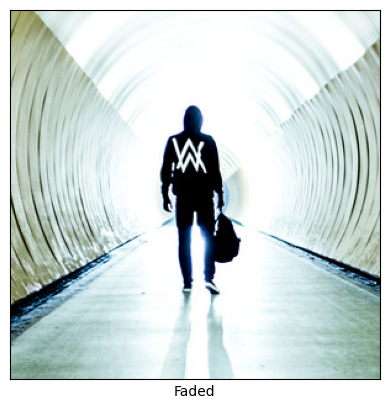

In [56]:
# Getting id of our chosen song
id = data[data["artists_song"] == name_song]["id"].iloc[0]
track = sp.track(id)

# API requisition
url = track["album"]["images"][1]["url"]
name = track["name"]

# Plotting image
image = io.imread(url)
plt.imshow(image)
plt.xlabel(name, fontsize=10)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.show()

## Geting playlist data

In [57]:
def recommend_id(playlist_id):
  url = []
  name = []
  artists= []

  for i in playlist_id:
    track = sp.track(i)
    url.append(track["album"]["images"][1]["url"])
    name.append(track["name"])
    artists.append(track["artists"][0]["name"])

  return name, url, artists

In [58]:
name, url, artists = recommend_id(recommended["id"])

In [59]:
name, url, artists

(['Faded',
  'Love U Better (feat. Lil Wayne & The-Dream)',
  'Orange Juice',
  'Verify (feat. Young Thug, Gunna)',
  'I Mean It (feat. Remo)',
  'Antidote',
  'Livin’ The Dream',
  'Halftime',
  'Big Lie',
  'IDGAF'],
 ['https://i.scdn.co/image/ab67616d00001e02c4d00cac55ae1b4598c9bc90',
  'https://i.scdn.co/image/ab67616d00001e0256f796c9039f52e90d015b4d',
  'https://i.scdn.co/image/ab67616d00001e025945e0dce1af45d640cf06ea',
  'https://i.scdn.co/image/ab67616d00001e02299995b90d0710682b1008ac',
  'https://i.scdn.co/image/ab67616d00001e02bdfe4efd674482cf5ac88c99',
  'https://i.scdn.co/image/ab67616d00001e02715973050587fe3c93033aad',
  'https://i.scdn.co/image/ab67616d00001e024aba6c802918af9a1aab311a',
  'https://i.scdn.co/image/ab67616d00001e0288053a98d0abb8ed3a02efe1',
  'https://i.scdn.co/image/ab67616d00001e0255404f712deb84d0650a4b41',
  'https://i.scdn.co/image/ab67616d00001e0255e36b0dc5b0ef008fc85319'],
 ['Alan Walker',
  'Ty Dolla $ign',
  'Melanie Martinez',
  'Jacquees',
  'G-Eaz

## Plotting playlist images

In [60]:
def visualize_songs(name, url, artists):
  plt.figure(figsize=(15, 10))
  columns = 5

  for i, u in enumerate(url):
    ax = plt.subplot(len(url) // columns + 1, columns, i + 1)

    image = io.imread(u)
    plt.imshow(image)

    ax.get_yaxis().set_visible(False)
    plt.xticks(color="w", fontsize=0.1)
    plt.yticks(color="w", fontsize=0.1)

    plt.xlabel(f"{artists[i]} - {name[i]}", fontsize=8)

    plt.tight_layout(h_pad=0.7, w_pad=0)

    plt.subplots_adjust(wspace=None, hspace=None)

    plt.tick_params(bottom=False)

    plt.grid(False)

  plt.show()

In [61]:
visualize_songs(name, url, artists)

# Making final function

In [62]:
def recommendator(name_song):
  cluster = list(projection_song[projection_song["song"] == name_song]["cluster_pca"])[0]

  recommended_songs = projection_song[projection_song["cluster_pca"] == cluster][[0, 1, "song"]]

  x_song = list(projection_song[projection_song["song"] == name_song][0])[0]
  y_song = list(projection_song[projection_song["song"] == name_song][1])[0]

  # Euclidean distances of nearest points to our song
  distances = euclidean_distances(recommended_songs[[0, 1]], [[x_song, y_song]])

  recommended_songs["id"] = data["id"]
  recommended_songs["distances"] = distances

  # Get top 10 recommended songs
  recommended = recommended_songs.sort_values("distances").head(10)

  name, url, artists = recommend_id(recommended["id"])

  visualize_songs(name, url, artists)

In [63]:
recommendator("Doja Cat - Say So")

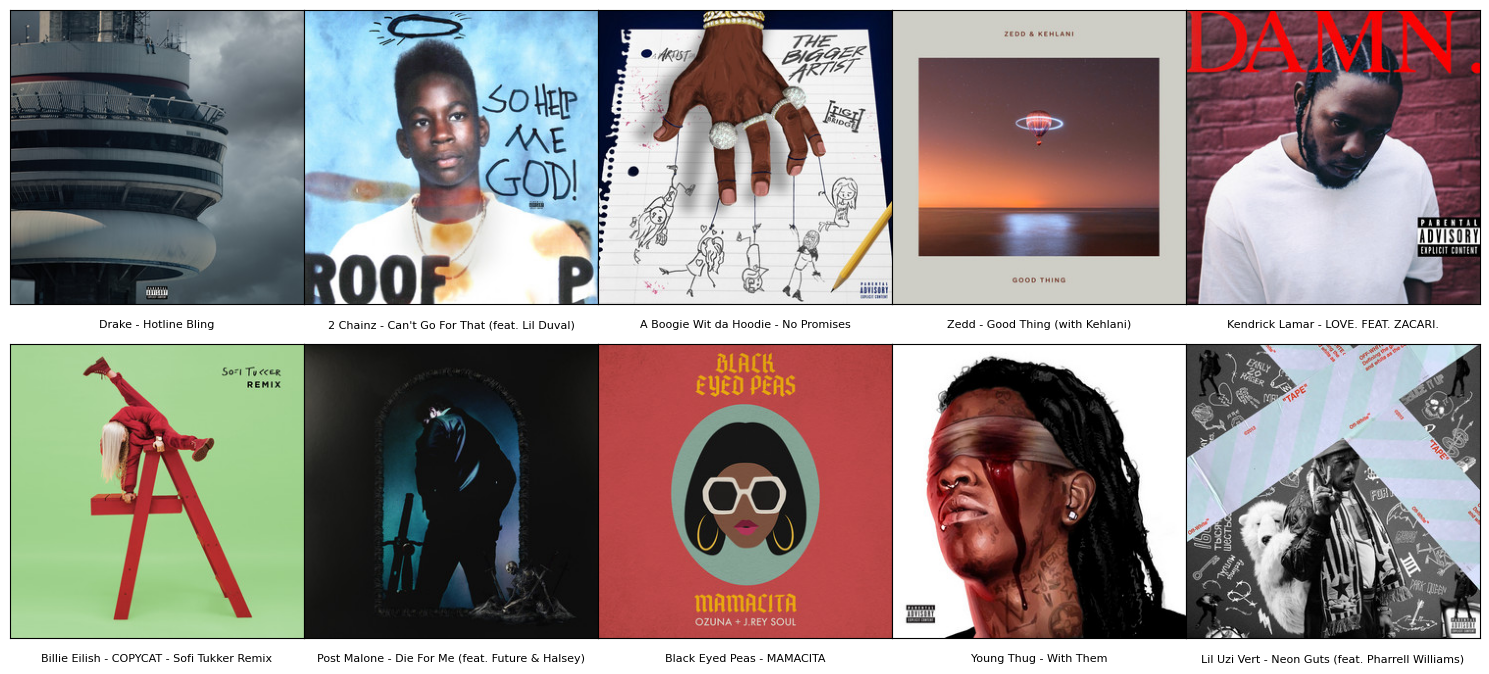

In [64]:
recommendator("Drake - Hotline Bling")